In this code, we include polynomial features derived from sleep details and total steps plus MOOD. We do factor analysis first, and then prediction of MOOD from all the input features from sleep details and total activity. 
Note: Polynomial features have been calculated before standardizing all the features. 

In [9]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.dimred import CORE
from scipy.linalg import eigh
from matplotlib.patches import Ellipse
from scipy.stats.distributions import chi2
from statsmodels.nonparametric.smoothers_lowess import lowess

In [10]:
df_sleep = pd.read_csv(r'C:\Users\rajnishk\OneDrive - Michigan Medicine\Documents\Student Wellness Dataset\student_wellness_sleep_details.csv',
                 parse_dates=["SLEEP_DATE","SLEEP_START_DATE", "SLEEP_END_DATE"],index_col=0)

In [11]:
df_MOOD = pd.read_csv(r'C:\Users\rajnishk\OneDrive - Michigan Medicine\Documents\Student Wellness Dataset\df_MOOD_SWG.csv', 
                     parse_dates=["METRIC_START_DATE", "METRIC_END_DATE"],index_col=0)

In [12]:
df_MOOD.rename(columns={'METRIC_START_DATE': 'SLEEP_DATE'}, inplace=True) # So that I can merge two dataframes. 


Generate variables in polar co-ordinates from sleep details

In [13]:
sleep_vars = ['ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN', 'LIGHT_COUNT', 
              'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT', 'ASLEEP_MIN', 'ASLEEP_COUNT', 
              'AWAKE_COUNT', 'AWAKE_MIN', 'RESTLESS_COUNT', 'RESTLESS_MIN']
v = df_sleep[sleep_vars].isna().sum(0)
v = v[v < 500].index.tolist()
vv = ["STUDY_PRTCPT_ID", "SLEEP_START_DATE", "SLEEP_END_DATE", "SLEEP_DATE"] + v
dx = df_sleep[vv].copy()
dx["YEARDAY"] = dx["SLEEP_DATE"].dt.dayofyear
dx["DAYOFWEEK"] = dx["SLEEP_DATE"].dt.dayofweek
dx["SLEEP_START_TIME"] = (dx["SLEEP_START_DATE"] - dx["SLEEP_START_DATE"].dt.normalize()) / pd.Timedelta(hours=1)
dx["SLEEP_END_TIME"] = (dx["SLEEP_END_DATE"] - dx["SLEEP_END_DATE"].dt.normalize()) / pd.Timedelta(hours=1)
dx["SLEEP_START_SIN"] = np.sin(2*np.pi*dx["SLEEP_START_TIME"]/24)
dx["SLEEP_START_COS"] = np.cos(2*np.pi*dx["SLEEP_START_TIME"]/24)
dx["SLEEP_END_SIN"] = np.sin(2*np.pi*dx["SLEEP_END_TIME"]/24)
dx["SLEEP_END_COS"] = np.cos(2*np.pi*dx["SLEEP_END_TIME"]/24)
dx["YEARDAY_SIN"] = np.sin(2*np.pi*dx["YEARDAY"]/366)
dx["YEARDAY_COS"] = np.cos(2*np.pi*dx["YEARDAY"]/366)

# #===============================================================================================
# dx["SLEEP_START_TIME"] = (dx["SLEEP_START_DATE"] - dx["SLEEP_START_DATE"].dt.normalize()) / pd.Timedelta(hours=1)
# plt.scatter(dx["SLEEP_START_TIME"],dx["SLEEP_START_SIN"] )
# #===============================================================================================


dx["STUDYDAY"] = dx["YEARDAY"] - dx.groupby("STUDY_PRTCPT_ID")["YEARDAY"].transform(np.min)
# dx = dx.drop(columns=["SLEEP_START_DATE", "SLEEP_END_DATE", "SLEEP_START_TIME", "SLEEP_END_TIME", "SLEEP_DATE"])
dx = dx.dropna()
dx.columns

C:\Users\rajnishk\AppData\Local\Temp\ipykernel_6412\1850505678.py:25: FutureWarning: The provided callable <function min at 0x0000027066465EE0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  dx["STUDYDAY"] = dx["YEARDAY"] - dx.groupby("STUDY_PRTCPT_ID")["YEARDAY"].transform(np.min)


Index(['STUDY_PRTCPT_ID', 'SLEEP_START_DATE', 'SLEEP_END_DATE', 'SLEEP_DATE',
       'ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN',
       'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT',
       'YEARDAY', 'DAYOFWEEK', 'SLEEP_START_TIME', 'SLEEP_END_TIME',
       'SLEEP_START_SIN', 'SLEEP_START_COS', 'SLEEP_END_SIN', 'SLEEP_END_COS',
       'YEARDAY_SIN', 'YEARDAY_COS', 'STUDYDAY'],
      dtype='object')

In [14]:
df_MOOD_sleep_polar = pd.merge(dx,df_MOOD, on = ['STUDY_PRTCPT_ID','SLEEP_DATE'], how = 'inner' )
df_MOOD_sleep_polar_MOOD_NZ = df_MOOD_sleep_polar[df_MOOD_sleep_polar.MOOD !=0]   # Lots of data goes away.

In [15]:
df_MOOD_sleep_polar_MOOD_NZ

,STUDY_PRTCPT_ID,SLEEP_START_DATE,SLEEP_END_DATE,SLEEP_DATE,ASLEEP_VALUE,INBED_VALUE,DEEP_MIN,DEEP_COUNT,LIGHT_MIN,LIGHT_COUNT,...,SLEEP_END_COS,YEARDAY_SIN,YEARDAY_COS,STUDYDAY,STUDY_METRIC_AGGREGATE_ID,STUDY_ID,STEP_COUNT,SLEEP_COUNT,MOOD,METRIC_END_DATE
0,XGJ8AFS8,2023-01-20 20:08:00,2023-01-21 05:48:30,2023-01-21,485,580,67.0,5.0,320.0,25.0,...,0.050157,0.352752,0.935717,0,4025733,401,6957,485,7,2023-01-21
1,XGJ8AFS8,2023-01-21 20:33:30,2023-01-22 07:55:30,2023-01-22,587,682,59.0,6.0,423.0,40.0,...,-0.482900,0.368763,0.929523,1,4031073,401,7395,587,8,2023-01-22
2,XGJ8AFS8,2023-01-22 19:37:30,2023-01-23 07:07:30,2023-01-23,561,690,71.0,5.0,394.0,40.0,...,-0.290285,0.384665,0.923056,2,4036413,401,7039,561,7,2023-01-23
3,XGJ8AFS8,2023-01-23 21:34:00,2023-01-24 06:02:30,2023-01-24,458,508,91.0,4.0,243.0,31.0,...,-0.010908,0.400454,0.916317,3,4041773,401,6257,458,7,2023-01-24
4,XGJ8AFS8,2023-01-24 20:20:30,2023-01-25 06:32:00,2023-01-25,492,611,44.0,4.0,360.0,30.0,...,-0.139173,0.416125,0.909308,4,4047133,401,3809,492,7,2023-01-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779,3IJBZPI8,2023-04-13 23:23:00,2023-04-14 07:01:00,2023-04-14,398,458,39.0,6.0,328.0,33.0,...,-0.263031,0.977064,-0.212947,43,4476751,401,115,398,7,2023-04-14
1787,JU3R5P4M,2023-03-28 00:14:30,2023-03-28 05:33:30,2023-03-28,263,319,23.0,2.0,189.0,19.0,...,0.115371,0.997018,0.077175,1,4380458,401,4729,263,2,2023-03-28
1788,JU3R5P4M,2023-03-29 01:38:30,2023-03-29 11:21:30,2023-03-29,481,583,56.0,2.0,390.0,47.0,...,-0.985923,0.998195,0.060049,2,4385858,401,1556,481,4,2023-03-29
1789,JU3R5P4M,2023-04-01 02:17:00,2023-04-01 18:04:00,2023-04-01,738,947,104.0,6.0,623.0,63.0,...,0.017452,0.999963,0.008583,5,4402280,401,1424,738,3,2023-04-01


In [16]:
abcd = df_MOOD_sleep_polar_MOOD_NZ.ASLEEP_VALUE - df_MOOD_sleep_polar_MOOD_NZ.SLEEP_COUNT
abcd[abcd!=0]

155    -178
156    -263
171     -53
178    -196
179    -269
       ... 
1734    -68
1735    -88
1737    -68
1746   -151
1757   -137
Length: 131, dtype: int64

In [17]:
df_MOOD_sleep_polar_MOOD_NZ.columns

Index(['STUDY_PRTCPT_ID', 'SLEEP_START_DATE', 'SLEEP_END_DATE', 'SLEEP_DATE',
       'ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN',
       'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT',
       'YEARDAY', 'DAYOFWEEK', 'SLEEP_START_TIME', 'SLEEP_END_TIME',
       'SLEEP_START_SIN', 'SLEEP_START_COS', 'SLEEP_END_SIN', 'SLEEP_END_COS',
       'YEARDAY_SIN', 'YEARDAY_COS', 'STUDYDAY', 'STUDY_METRIC_AGGREGATE_ID',
       'STUDY_ID', 'STEP_COUNT', 'SLEEP_COUNT', 'MOOD', 'METRIC_END_DATE'],
      dtype='object')

In [18]:
columns_for_norm = ['ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN',
       'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT','STEP_COUNT', 'SLEEP_COUNT', 'MOOD']

Normalize the sleep detail variables, total step variable, and MOOD. I am normalizing the MOOD because it is a part of factor analysis, and it might be interesting to see the appearance of MOOD in the vicinity of other sleep variables. 

In [19]:
df_MOOD_sleep_polar_MOOD_NZ_norm = df_MOOD_sleep_polar_MOOD_NZ.copy()
df_MOOD_sleep_polar_MOOD_NZ_norm[columns_for_norm] = df_MOOD_sleep_polar_MOOD_NZ_norm[columns_for_norm]- df_MOOD_sleep_polar_MOOD_NZ_norm[columns_for_norm].mean(0)
df_MOOD_sleep_polar_MOOD_NZ_norm[columns_for_norm] = df_MOOD_sleep_polar_MOOD_NZ_norm[columns_for_norm]/df_MOOD_sleep_polar_MOOD_NZ_norm[columns_for_norm].std(0)
df_MOOD_sleep_polar_MOOD_NZ_norm

,STUDY_PRTCPT_ID,SLEEP_START_DATE,SLEEP_END_DATE,SLEEP_DATE,ASLEEP_VALUE,INBED_VALUE,DEEP_MIN,DEEP_COUNT,LIGHT_MIN,LIGHT_COUNT,...,SLEEP_END_COS,YEARDAY_SIN,YEARDAY_COS,STUDYDAY,STUDY_METRIC_AGGREGATE_ID,STUDY_ID,STEP_COUNT,SLEEP_COUNT,MOOD,METRIC_END_DATE
0,XGJ8AFS8,2023-01-20 20:08:00,2023-01-21 05:48:30,2023-01-21,0.673706,0.844594,-0.079295,0.954446,0.867428,-0.151096,...,0.050157,0.352752,0.935717,0,4025733,401,-0.148212,0.314335,0.272990,2023-01-21
1,XGJ8AFS8,2023-01-21 20:33:30,2023-01-22 07:55:30,2023-01-22,1.544407,1.603654,-0.375125,1.618529,2.123036,1.387767,...,-0.482900,0.368763,0.929523,1,4031073,401,-0.055628,1.214312,0.823579,2023-01-22
2,XGJ8AFS8,2023-01-22 19:37:30,2023-01-23 07:07:30,2023-01-23,1.322464,1.663188,0.068619,0.954446,1.769515,1.387767,...,-0.290285,0.384665,0.923056,2,4036413,401,-0.130879,0.984906,0.272990,2023-01-23
3,XGJ8AFS8,2023-01-23 21:34:00,2023-01-24 06:02:30,2023-01-24,0.443226,0.308787,0.808193,0.290363,-0.071229,0.464449,...,-0.010908,0.400454,0.916317,3,4041773,401,-0.296177,0.076106,0.272990,2023-01-24
4,XGJ8AFS8,2023-01-24 20:20:30,2023-01-25 06:32:00,2023-01-25,0.733460,1.075288,-0.929805,0.290363,1.355043,0.361858,...,-0.139173,0.416125,0.909308,4,4047133,401,-0.813634,0.376098,0.272990,2023-01-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779,3IJBZPI8,2023-04-13 23:23:00,2023-04-14 07:01:00,2023-04-14,-0.068951,-0.063302,-1.114699,1.618529,0.964951,0.669631,...,-0.263031,0.977064,-0.212947,43,4476751,401,-1.594469,-0.453293,0.272990,2023-04-14
1787,JU3R5P4M,2023-03-28 00:14:30,2023-03-28 05:33:30,2023-03-28,-1.221350,-1.097707,-1.706358,-1.037803,-0.729509,-0.766641,...,0.115371,0.997018,0.077175,1,4380458,401,-0.619165,-1.644439,-2.479951,2023-03-28
1788,JU3R5P4M,2023-03-29 01:38:30,2023-03-29 11:21:30,2023-03-29,0.639561,0.866919,-0.486061,-1.037803,1.720754,2.105903,...,-0.985923,0.998195,0.060049,2,4385858,401,-1.289871,0.279042,-1.378774,2023-03-29
1789,JU3R5P4M,2023-04-01 02:17:00,2023-04-01 18:04:00,2023-04-01,2.833387,3.575722,1.288917,1.618529,4.561108,3.747357,...,0.017452,0.999963,0.008583,5,4402280,401,-1.317774,2.546631,-1.929363,2023-04-01


Calculating polynomial features. We will only include product of features, e.g. x1*x2 etc., and not x1^2, x2^2 and so on. 

In [20]:
from sklearn.preprocessing import PolynomialFeatures

In [21]:
interacting_features = columns_for_norm
rest_of_features = list(set(df_MOOD_sleep_polar_MOOD_NZ_norm.columns) - set(columns_for_norm))
rest_of_features

['SLEEP_END_COS',
 'SLEEP_START_COS',
 'YEARDAY_SIN',
 'SLEEP_START_SIN',
 'SLEEP_START_TIME',
 'METRIC_END_DATE',
 'SLEEP_END_SIN',
 'YEARDAY_COS',
 'SLEEP_END_DATE',
 'DAYOFWEEK',
 'SLEEP_DATE',
 'SLEEP_END_TIME',
 'STUDYDAY',
 'STUDY_PRTCPT_ID',
 'STUDY_METRIC_AGGREGATE_ID',
 'SLEEP_START_DATE',
 'YEARDAY',
 'STUDY_ID']

In [22]:
df_MOOD_sleep_polar_MOOD_NZ_norm[interacting_features]

,ASLEEP_VALUE,INBED_VALUE,DEEP_MIN,DEEP_COUNT,LIGHT_MIN,LIGHT_COUNT,REM_MIN,REM_COUNT,WAKE_MIN,WAKE_COUNT,STEP_COUNT,SLEEP_COUNT,MOOD
0,0.673706,0.844594,-0.079295,0.954446,0.867428,-0.151096,0.261434,0.232651,1.469280,0.098242,-0.148212,0.314335,0.272990
1,1.544407,1.603654,-0.375125,1.618529,2.123036,1.387767,0.446099,-0.004971,1.469280,1.198856,-0.055628,1.214312,0.823579
2,1.322464,1.663188,0.068619,0.954446,1.769515,1.387767,0.208673,-0.242594,2.903869,0.923703,-0.130879,0.984906,0.272990
3,0.443226,0.308787,0.808193,0.290363,-0.071229,0.464449,0.947333,0.707896,-0.429441,0.556831,-0.296177,0.076106,0.272990
4,0.733460,1.075288,-0.929805,0.290363,1.355043,0.361858,-0.002373,0.232651,2.481931,0.189960,-0.813634,0.376098,0.272990
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779,-0.068951,-0.063302,-1.114699,1.618529,0.964951,0.669631,-1.506075,-0.480216,-0.007503,-0.452065,-1.594469,-0.453293,0.272990
1787,-1.221350,-1.097707,-1.706358,-1.037803,-0.729509,-0.766641,-0.978460,-0.480216,-0.176278,-0.635501,-0.619165,-1.644439,-2.479951
1788,0.639561,0.866919,-0.486061,-1.037803,1.720754,2.105903,-1.400552,-1.193084,1.764636,1.932599,-1.289871,0.279042,-1.378774
1789,2.833387,3.575722,1.288917,1.618529,4.561108,3.747357,-2.033689,-1.430706,6.279373,3.033213,-1.317774,2.546631,-1.929363


In [23]:
interacting_features

['ASLEEP_VALUE',
 'INBED_VALUE',
 'DEEP_MIN',
 'DEEP_COUNT',
 'LIGHT_MIN',
 'LIGHT_COUNT',
 'REM_MIN',
 'REM_COUNT',
 'WAKE_MIN',
 'WAKE_COUNT',
 'STEP_COUNT',
 'SLEEP_COUNT',
 'MOOD']

In [24]:
# Excluding MOOD from interacting features
X = df_MOOD_sleep_polar_MOOD_NZ_norm[['ASLEEP_VALUE',  'INBED_VALUE',  'DEEP_MIN',  'DEEP_COUNT',  'LIGHT_MIN',  'LIGHT_COUNT',
 'REM_MIN',  'REM_COUNT',  'WAKE_MIN',  'WAKE_COUNT',  'STEP_COUNT',  'SLEEP_COUNT']]
X_remain_feature = df_MOOD_sleep_polar_MOOD_NZ_norm[['MOOD']]
degree = 2
# Create the PolynomialFeatures object with specified degree
poly = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=True)

# Create the polynomial features and fit them to the input features
X_poly = poly.fit_transform(X)

In [25]:
# Generate the feature names for the polynomial features
feature_names = poly.get_feature_names_out(['ASLEEP_VALUE',  'INBED_VALUE',  'DEEP_MIN',  'DEEP_COUNT',  'LIGHT_MIN',  'LIGHT_COUNT',
 'REM_MIN',  'REM_COUNT',  'WAKE_MIN',  'WAKE_COUNT',  'STEP_COUNT',  'SLEEP_COUNT'])
# Create a DataFrame with the newly created polynomial features
df_poly = pd.DataFrame(X_poly, columns=feature_names)
# Concatenate the feature 'x4' to the polynomial features DataFrame
df_final = pd.concat([df_poly, X_remain_feature.reset_index(drop=True)], axis=1)

df_final
                                         

,ASLEEP_VALUE,INBED_VALUE,DEEP_MIN,DEEP_COUNT,LIGHT_MIN,LIGHT_COUNT,REM_MIN,REM_COUNT,WAKE_MIN,WAKE_COUNT,...,REM_COUNT WAKE_COUNT,REM_COUNT STEP_COUNT,REM_COUNT SLEEP_COUNT,WAKE_MIN WAKE_COUNT,WAKE_MIN STEP_COUNT,WAKE_MIN SLEEP_COUNT,WAKE_COUNT STEP_COUNT,WAKE_COUNT SLEEP_COUNT,STEP_COUNT SLEEP_COUNT,MOOD
0,0.673706,0.844594,-0.079295,0.954446,0.867428,-0.151096,0.261434,0.232651,1.469280,0.098242,...,0.022856,-0.034482,0.073130,0.144345,-0.217765,0.461846,-0.014561,0.030881,-0.046588,0.272990
1,1.544407,1.603654,-0.375125,1.618529,2.123036,1.387767,0.446099,-0.004971,1.469280,1.198856,...,-0.005960,0.000277,-0.006037,1.761455,-0.081733,1.784164,-0.066690,1.455785,-0.067549,0.823579
2,1.322464,1.663188,0.068619,0.954446,1.769515,1.387767,0.208673,-0.242594,2.903869,0.923703,...,-0.224084,0.031750,-0.238932,2.682311,-0.380055,2.860037,-0.120893,0.909760,-0.128903,0.272990
3,0.443226,0.308787,0.808193,0.290363,-0.071229,0.464449,0.947333,0.707896,-0.429441,0.556831,...,0.394179,-0.209663,0.053875,-0.239126,0.127191,-0.032683,-0.164921,0.042378,-0.022541,0.272990
4,0.733460,1.075288,-0.929805,0.290363,1.355043,0.361858,-0.002373,0.232651,2.481931,0.189960,...,0.044194,-0.189293,0.087500,0.471467,-2.019383,0.933449,-0.154558,0.071443,-0.306006,0.272990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,-0.068951,-0.063302,-1.114699,1.618529,0.964951,0.669631,-1.506075,-0.480216,-0.007503,-0.452065,...,0.217089,0.765690,0.217678,0.003392,0.011963,0.003401,0.720804,0.204918,0.722761,0.272990
474,-1.221350,-1.097707,-1.706358,-1.037803,-0.729509,-0.766641,-0.978460,-0.480216,-0.176278,-0.635501,...,0.305178,0.297333,0.789686,0.112025,0.109145,0.289879,0.393480,1.045043,1.018179,-2.479951
475,0.639561,0.866919,-0.486061,-1.037803,1.720754,2.105903,-1.400552,-1.193084,1.764636,1.932599,...,-2.305753,1.538925,-0.332920,3.410335,-2.276154,0.492407,-2.492804,0.539276,-0.359928,-1.378774
476,2.833387,3.575722,1.288917,1.618529,4.561108,3.747357,-2.033689,-1.430706,6.279373,3.033213,...,-4.339638,1.885347,-3.643481,19.046678,-8.274791,15.991242,-3.997088,7.724474,-3.355882,-1.929363


In [26]:
dx = df_final
va = df_final.columns
va

Index(['ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN',
       'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT',
       'STEP_COUNT', 'SLEEP_COUNT', 'ASLEEP_VALUE INBED_VALUE',
       'ASLEEP_VALUE DEEP_MIN', 'ASLEEP_VALUE DEEP_COUNT',
       'ASLEEP_VALUE LIGHT_MIN', 'ASLEEP_VALUE LIGHT_COUNT',
       'ASLEEP_VALUE REM_MIN', 'ASLEEP_VALUE REM_COUNT',
       'ASLEEP_VALUE WAKE_MIN', 'ASLEEP_VALUE WAKE_COUNT',
       'ASLEEP_VALUE STEP_COUNT', 'ASLEEP_VALUE SLEEP_COUNT',
       'INBED_VALUE DEEP_MIN', 'INBED_VALUE DEEP_COUNT',
       'INBED_VALUE LIGHT_MIN', 'INBED_VALUE LIGHT_COUNT',
       'INBED_VALUE REM_MIN', 'INBED_VALUE REM_COUNT', 'INBED_VALUE WAKE_MIN',
       'INBED_VALUE WAKE_COUNT', 'INBED_VALUE STEP_COUNT',
       'INBED_VALUE SLEEP_COUNT', 'DEEP_MIN DEEP_COUNT', 'DEEP_MIN LIGHT_MIN',
       'DEEP_MIN LIGHT_COUNT', 'DEEP_MIN REM_MIN', 'DEEP_MIN REM_COUNT',
       'DEEP_MIN WAKE_MIN', 'DEEP_MIN WAKE_COUNT', 'DEEP_MIN STEP_COUNT',
       'D

# PCA/biplots

In [27]:
def plot_eigs(eigs):
    jj = np.arange(1, len(eigs) + 1)
    ii = np.flatnonzero(eigs >= 1e-10)
    plt.clf()
    plt.grid(True)
    plt.plot(np.log(jj[ii]), np.log(eigs[ii]), "-o")
    # plt.plot((jj[ii]), (eigs[ii]), "-o")
    
    plt.ylabel("Log eigenvalue", size=15)
    plt.xlabel("Log position", size=15)
    plt.show()

In [28]:
def varimax(X, eps=1e-05, maxiter=1000):
    G = X.copy()
    m, p = G.shape
    Q = np.eye(p)
    if p < 2: 
        return G, Q
    d = 0.0
    for i in range(maxiter):
        z = np.dot(G, Q)
        cs = (z**2).sum(0)
        B = np.dot(G.T, z**3 - z * (cs / m))
        u, s, vt = np.linalg.svd(B, 0)
        Q = np.dot(u, vt)
        dlast = d
        d = s.sum()
        if d < dlast * (1 + eps): 
            break
            
    G = np.dot(G, Q)
    return G, Q

In [29]:
def ellipse_plot(U, idx, j0, j1):
    r2 = chi2(2).ppf(0.95)
    rr = np.sqrt(r2)
    dx = pd.DataFrame({"u0": U[:, 0], "u1": U[:, 1], "id": idx})
    plt.clf()
    plt.figure(figsize=(10, 10))
    plt.grid(True)
    plt.plot(dx["u0"], dx["u1"], "o", color="black", alpha=0.05)
    for (ky,dg) in dx.groupby("id"):
        if dg.shape[0] > 10:
            m0, m1 = dg["u0"].mean(), dg["u1"].mean()
            C = np.cov(dg["u0"], dg["u1"])
            a, b = eigh(C)
            plt.plot([m0], [m1], "o", color="blue", ms=8, alpha=0.2)
            ang = np.arctan2(b[1, 1], b[0, 1])*360/(2*np.pi)
            E = Ellipse(xy=[m0,m1], width=rr*np.sqrt(a[1]), height=rr*np.sqrt(a[0]), fc="none", ec="black", angle=ang)
            plt.gca().add_artist(E)
    plt.xlabel("Component %d" % j0, size=17)
    plt.ylabel("Component %d" % j1, size=17)
    plt.show()

va is Index(['ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN',
       'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT',
       'STEP_COUNT', 'SLEEP_COUNT', 'ASLEEP_VALUE INBED_VALUE',
       'ASLEEP_VALUE DEEP_MIN', 'ASLEEP_VALUE DEEP_COUNT',
       'ASLEEP_VALUE LIGHT_MIN', 'ASLEEP_VALUE LIGHT_COUNT',
       'ASLEEP_VALUE REM_MIN', 'ASLEEP_VALUE REM_COUNT',
       'ASLEEP_VALUE WAKE_MIN', 'ASLEEP_VALUE WAKE_COUNT',
       'ASLEEP_VALUE STEP_COUNT', 'ASLEEP_VALUE SLEEP_COUNT',
       'INBED_VALUE DEEP_MIN', 'INBED_VALUE DEEP_COUNT',
       'INBED_VALUE LIGHT_MIN', 'INBED_VALUE LIGHT_COUNT',
       'INBED_VALUE REM_MIN', 'INBED_VALUE REM_COUNT', 'INBED_VALUE WAKE_MIN',
       'INBED_VALUE WAKE_COUNT', 'INBED_VALUE STEP_COUNT',
       'INBED_VALUE SLEEP_COUNT', 'DEEP_MIN DEEP_COUNT', 'DEEP_MIN LIGHT_MIN',
       'DEEP_MIN LIGHT_COUNT', 'DEEP_MIN REM_MIN', 'DEEP_MIN REM_COUNT',
       'DEEP_MIN WAKE_MIN', 'DEEP_MIN WAKE_COUNT', 'DEEP_MIN STEP_COUNT',
   

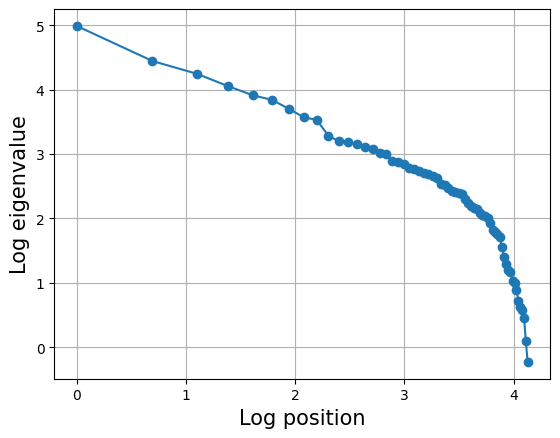

<Figure size 640x480 with 0 Axes>

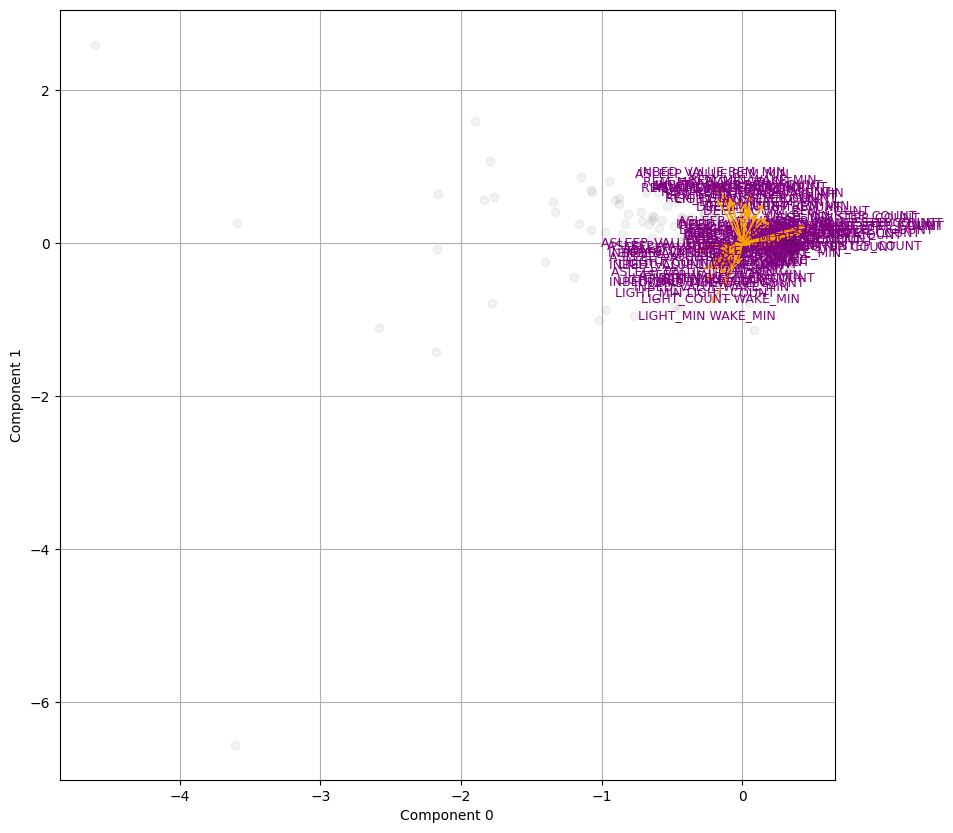

KeyError: 'STUDY_PRTCPT_ID'

In [30]:
def biplot(dx, va, j=0, k=1, d=5, rotate=False, scree=False, ellipses=False):
    assert d > max(j, k)
    dx = dx.copy()
    X = np.asarray(dx[va])
    n, p = X.shape
    X -= X.mean()
    X -= X.mean(0)
    u, s, vt = np.linalg.svd(X, 0)
    v = vt.T
    if scree:
        plot_eigs(s)
    uu = u[:, 0:d]
    vv = v[:, 0:d]
    ss = s[0:d]
    if rotate:
        uu, Ru = varimax(uu)
        uu *= np.sqrt(n)
        vv, Rv = varimax(vv)
        vv *= np.sqrt(p)
        B = np.dot(Ru.T * ss, Rv) / np.sqrt(n*p)
    else:
        uu *= (ss**0.5)
        vv *= (ss**0.5)
        B = np.eye(d)
        
    ff = np.sqrt(X.shape[0] / X.shape[1]) # May need to adjust this
    v /= ff
    plt.clf()
    plt.figure(figsize=(10, 10))
    plt.grid(True)
    plt.plot(uu[:, j], uu[:, k], "o", color="black", alpha=0.05)
    for i in range(v.shape[0]):
        
        plt.annotate(va[i], xy=(0, 0), xytext=(vv[i, j], vv[i, k]), 
                     arrowprops=dict(color='orange', arrowstyle="<-"), color="purple", size=9)
    plt.xlabel("Component %d" % j)
    plt.ylabel("Component %d" % k)
    plt.show()
    
    if ellipses:
        ellipse_plot(uu[:, [j, k]], dx["STUDY_PRTCPT_ID"], j,k)
print("va is %s" %va)        
biplot(dx, va, 0, 1, d=5, rotate=False, scree=True, ellipses=True)
biplot(dx, va, 2, 3, d=5, rotate=False, ellipses=True)
biplot(dx, va, 0, 1, d=5, rotate=True, ellipses=True)
biplot(dx, va, 2, 3, d=5, rotate=True, ellipses=True)